In [66]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

In [67]:
df = pd.read_csv('~/Bureau/Datasets/TimeSeries/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


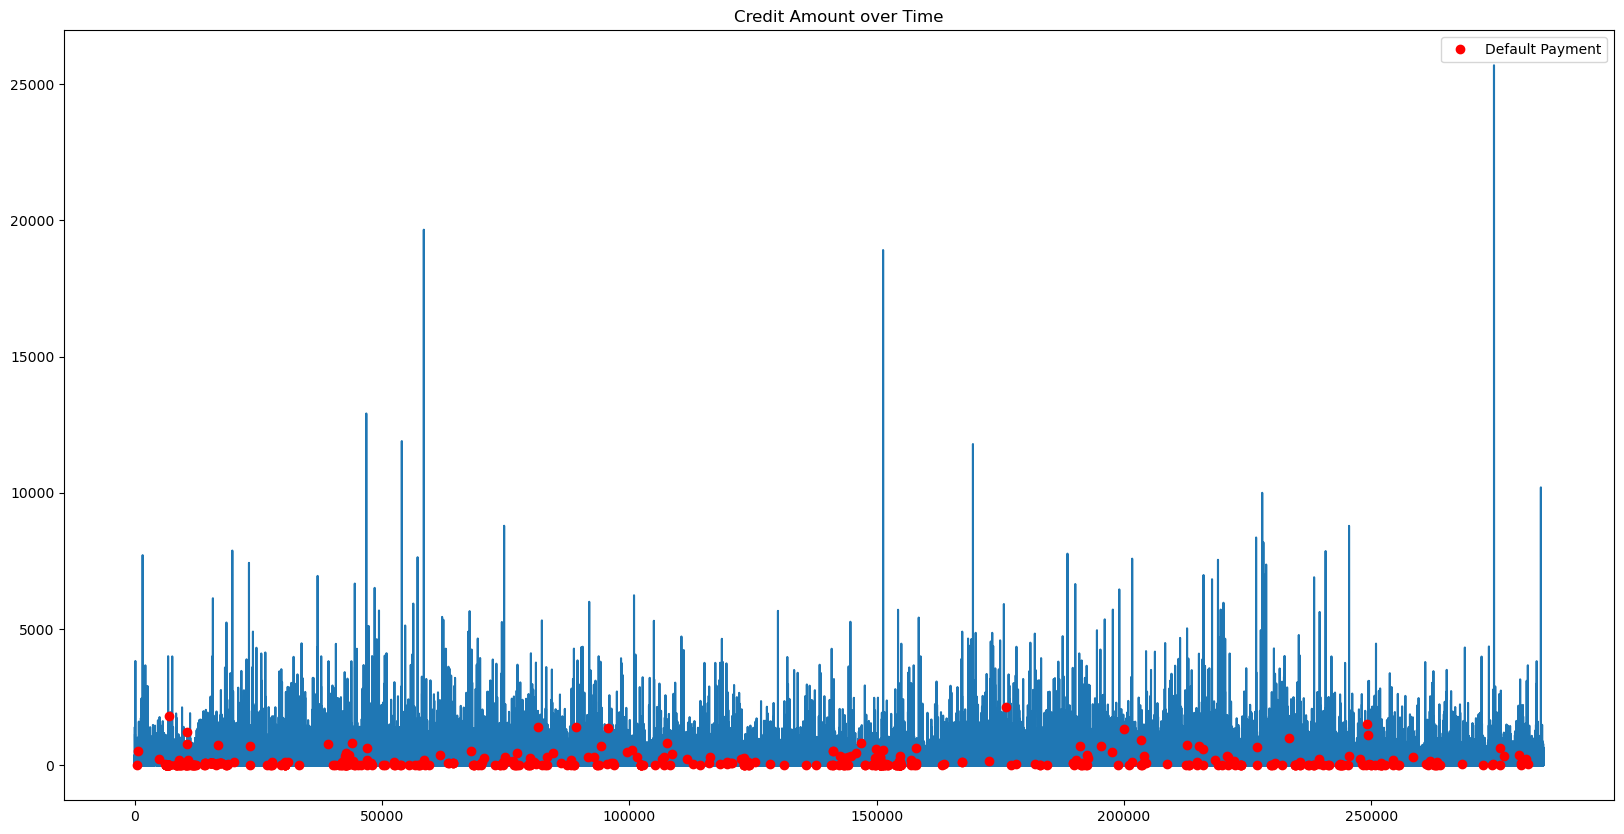

In [68]:
plt.figure(figsize=(20, 10))

value = df['Amount']
anomalies = df['Class']

indices = range(len(value))
anomalies_indices = [i for i in df[df['Class']==1].index]

plt.plot(indices, value)
plt.plot( anomalies_indices, value[anomalies_indices], "ro", label="Default Payment")
plt.title("Credit Amount over Time")
plt.legend()

In [69]:
train_size = int(0.6*len(df))

train = df.iloc[:train_size]
test = df.iloc[train_size:]

train = train[train['Class']==0]

df = pd.concat([train, test])
df = df.reset_index(drop=True)

In [70]:
# Number of transaction each second (respect of the time series)

df['transactions_seconds']=1

for i in range(1, len(df)):
    t = df.loc[i, 'Time']
    t1 = df.loc[i-1, 'Time']
    if t==t1:
        df.loc[i, 'transactions_seconds'] = df.loc[i-1, 'transactions_seconds'] + 1

In [71]:
train_size = int(0.6*len(df))

train = df.iloc[:train_size]
test = df.iloc[train_size:]

train = train[train['Class']==0]

df = pd.concat([train, test])
df = df.reset_index(drop=True)

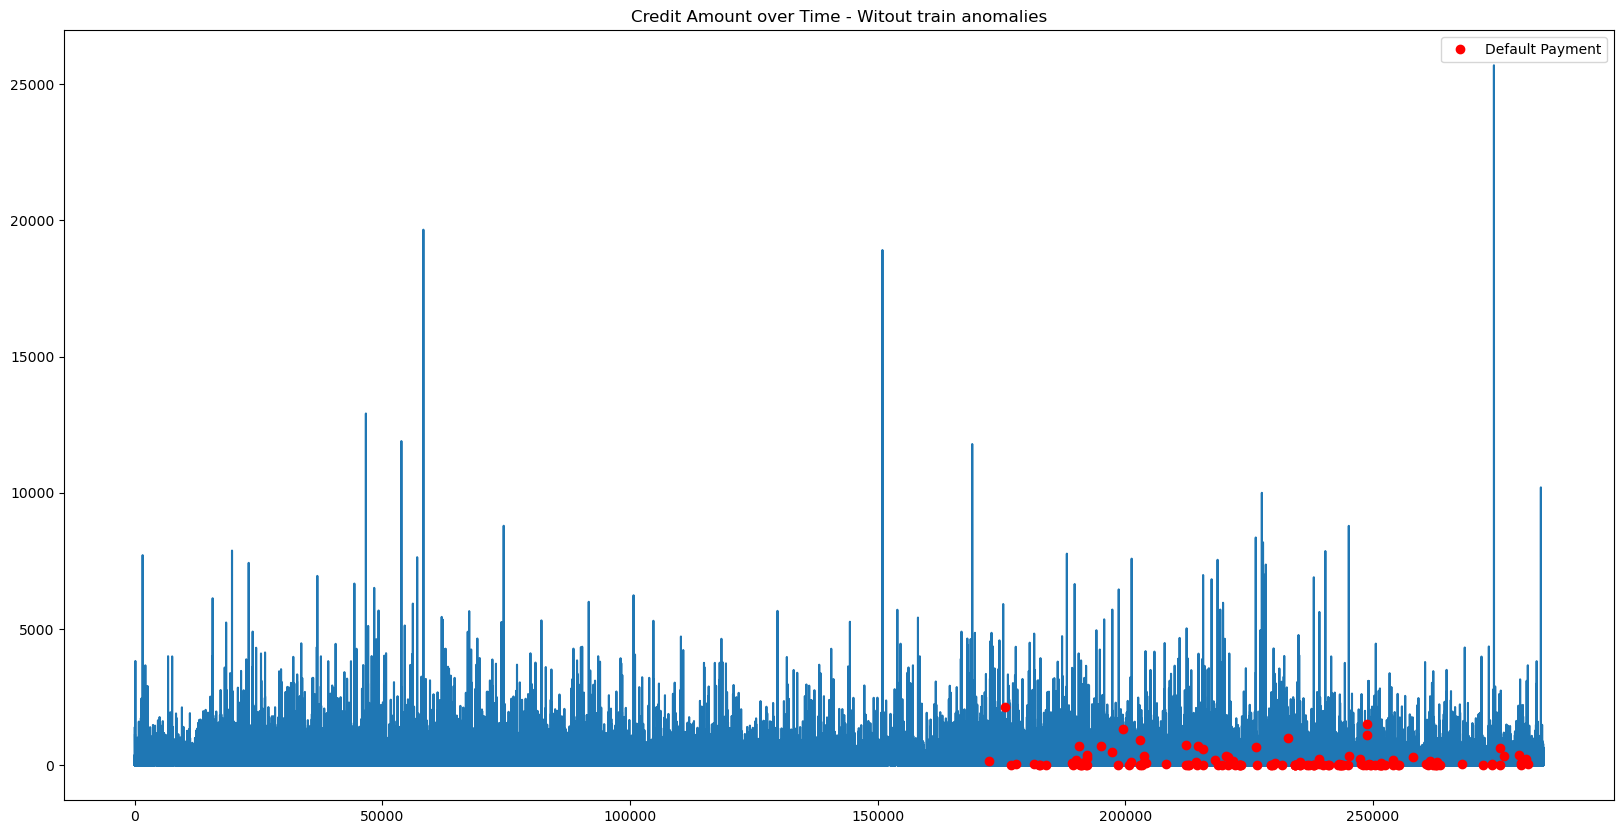

In [72]:
plt.figure(figsize=(20, 10))

value = df['Amount']
anomalies = df['Class']

indices = range(len(value))
anomalies_indices = [i for i in df[df['Class']==1].index]

plt.plot(indices, value)
plt.plot( anomalies_indices, value[anomalies_indices], "ro", label="Default Payment")
plt.title("Credit Amount over Time - Witout train anomalies")
plt.legend()

In [73]:
scaler = StandardScaler()

train['Amount'] = scaler.fit_transform(train['Amount'].values.reshape(-1, 1))
test['Amount'] = scaler.transform(test['Amount'].values.reshape(-1, 1))

In [74]:
class TSDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        subdf = self.df.iloc[index]
        features = subdf.drop(['Time', 'Class']).values
        tar = subdf['Class'].item()
        return torch.Tensor(features), 1-torch.tensor(tar)
    
trainset = TSDataset(train)
first = trainset[0]
print(first[0].shape, first[1])

torch.Size([30]) tensor(1.)


In [75]:
#trainer class for DROCC
class DROCCTrainer:
    """
    Trainer class that implements the DROCC algorithm proposed in
    https://arxiv.org/abs/2002.12718
    """

    def __init__(self, model, optimizer, lamda, radius, gamma, device):
        """Initialize the DROCC Trainer class

        Parameters
        ----------
        model: Torch neural network object
        optimizer: Total number of epochs for training.
        lamda: Weight given to the adversarial loss
        radius: Radius of hypersphere to sample points from.
        gamma: Parameter to vary projection.
        device: torch.device object for device to use.
        """     
        self.model = model
        self.optimizer = optimizer
        self.lamda = lamda
        self.radius = radius
        self.gamma = gamma
        self.device = device

    def train(self, train_loader, learning_rate, lr_scheduler, total_epochs, 
                only_ce_epochs=50, ascent_step_size=0.001, ascent_num_steps=50):
        """Trains the model on the given training dataset with periodic 
        evaluation on the validation dataset.

        Parameters
        ----------
        train_loader: Dataloader object for the training dataset.
        val_loader: Dataloader object for the validation dataset.
        learning_rate: Initial learning rate for training.
        total_epochs: Total number of epochs for training.
        only_ce_epochs: Number of epochs for initial pretraining.
        ascent_step_size: Step size for gradient ascent for adversarial 
                          generation of negative points.
        ascent_num_steps: Number of gradient ascent steps for adversarial 
                          generation of negative points.
        metric: Metric used for evaluation (AUC / F1).
        """

        self.ascent_num_steps = ascent_num_steps
        self.ascent_step_size = ascent_step_size
        for epoch in range(total_epochs): 
            #Make the weights trainable
            self.model.train()
            lr_scheduler(epoch, total_epochs, only_ce_epochs, learning_rate, self.optimizer)
            
            #Placeholder for the respective 2 loss values
            epoch_adv_loss = torch.tensor([0]).type(torch.float32).to(self.device)  #AdvLoss
            epoch_ce_loss = 0  #Cross entropy Loss
            
            batch_idx = -1
            for data, target in tqdm(train_loader):
                batch_idx += 1
                data, target = data.to(self.device), target.to(self.device)
                # Data Processing
                data = data.to(torch.float)
                target = target.to(torch.float)
                target = torch.squeeze(target)

                self.optimizer.zero_grad()
                
                # Extract the logits for cross entropy loss
                logits = self.model(data)
                logits = torch.squeeze(logits, dim = 1)
                ce_loss = F.binary_cross_entropy_with_logits(logits, target)
                # Add to the epoch variable for printing average CE Loss
                epoch_ce_loss += ce_loss

                '''
                Adversarial Loss is calculated only for the positive data points (label==1).
                '''
                if  epoch >= only_ce_epochs:
                    data = data[target == 1]
                    # AdvLoss 
                    adv_loss = self.one_class_adv_loss(data)
                    epoch_adv_loss += adv_loss

                    loss = ce_loss + adv_loss * self.lamda
                else: 
                    # If only CE based training has to be done
                    loss = ce_loss
                
                # Backprop
                loss.backward()
                self.optimizer.step()
                    
            epoch_ce_loss = epoch_ce_loss/(batch_idx + 1)  #Average CE Loss
            epoch_adv_loss = epoch_adv_loss/(batch_idx + 1) #Average AdvLoss

            print('Epoch: {}, CE Loss: {}, AdvLoss: {}'.format(
                epoch, epoch_ce_loss.item(), epoch_adv_loss.item()))   
    
    def one_class_adv_loss(self, x_train_data):
        """Computes the adversarial loss:
        1) Sample points initially at random around the positive training
            data points
        2) Gradient ascent to find the most optimal point in set N_i(r) 
            classified as +ve (label=0). This is done by maximizing 
            the CE loss wrt label 0
        3) Project the points between spheres of radius R and gamma * R 
            (set N_i(r))
        4) Pass the calculated adversarial points through the model, 
            and calculate the CE loss wrt target class 0
        
        Parameters
        ----------
        x_train_data: Batch of data to compute loss on.
        """
        batch_size = len(x_train_data)
        # Randomly sample points around the training data
        # We will perform SGD on these to find the adversarial points
        x_adv = torch.randn(x_train_data.shape).to(self.device).detach().requires_grad_()
        x_adv_sampled = x_adv + x_train_data

        for step in range(self.ascent_num_steps):
            with torch.enable_grad():

                new_targets = torch.zeros(batch_size, 1).to(self.device)
                new_targets = torch.squeeze(new_targets)
                new_targets = new_targets.to(torch.float)
                
                logits = self.model(x_adv_sampled)         
                logits = torch.squeeze(logits, dim = 1)
                new_loss = F.binary_cross_entropy_with_logits(logits, new_targets)

                grad = torch.autograd.grad(new_loss, [x_adv_sampled])[0]
                grad_norm = torch.norm(grad, p=2, dim = tuple(range(1, grad.dim())))
                grad_norm = grad_norm.view(-1, *[1]*(grad.dim()-1))
                grad_normalized = grad/grad_norm 
            with torch.no_grad():
                x_adv_sampled.add_(self.ascent_step_size * grad_normalized)

            if (step + 1) % 10==0:
                # Project the normal points to the set N_i(r)
                h = x_adv_sampled - x_train_data
                norm_h = torch.sqrt(torch.sum(h**2, 
                                                dim=tuple(range(1, h.dim()))))
                alpha = torch.clamp(norm_h, self.radius, 
                                    self.gamma * self.radius).to(self.device)
                # Make use of broadcast to project h
                proj = (alpha/norm_h).view(-1, *[1] * (h.dim()-1))
                h = proj * h
                x_adv_sampled = x_train_data + h  #These adv_points are now on the surface of hyper-sphere

        adv_pred = self.model(x_adv_sampled)
        adv_pred = torch.squeeze(adv_pred, dim=1)
        adv_loss = F.binary_cross_entropy_with_logits(adv_pred, (new_targets * 0))
        assert not torch.isnan(adv_loss), "NAN"
        return adv_loss

In [76]:
def adjust_learning_rate(epoch, total_epochs, only_ce_epochs, learning_rate, optimizer):
        """Adjust learning rate during training.

        Parameters
        ----------
        epoch: Current training epoch.
        total_epochs: Total number of epochs for training.
        only_ce_epochs: Number of epochs for initial pretraining.
        learning_rate: Initial learning rate for training.
        """
        #We dont want to consider the only ce 
        #based epochs for the lr scheduler
        epoch = epoch - only_ce_epochs
        drocc_epochs = total_epochs - only_ce_epochs
        # lr = learning_rate
        if epoch <= drocc_epochs:
            lr = learning_rate * 0.001
        if epoch <= 0.90 * drocc_epochs:
            lr = learning_rate * 0.01  
        if epoch <= 0.60 * drocc_epochs:
            lr = learning_rate * 0.1  
        if epoch <= 0.30 * drocc_epochs:
            lr = learning_rate    
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        return optimizer

In [141]:
LR=1e-3
EPOCHS=4
BATCH_SIZE=256

CE_EPOCHS=1
ASCENT_STEP_SIZE=0.1
ASCENT_NUM_STEPS=50

GAMMA=2
LAMBDA=1
RADIUS=10

DEVICE="cuda"

In [142]:
trainset = TSDataset(train)
testset = TSDataset(test)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

In [143]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.seq = nn.Sequential(
            nn.Linear(30, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.seq(x)

In [144]:
model = Classifier().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

In [145]:
trainer = DROCCTrainer(model, optimizer, lamda=LAMBDA, radius=RADIUS, gamma=GAMMA, device=DEVICE)

In [ ]:
trainer.train(trainloader, learning_rate=LR, lr_scheduler=adjust_learning_rate, total_epochs=EPOCHS,
             ascent_step_size=ASCENT_STEP_SIZE, ascent_num_steps=ASCENT_NUM_STEPS, only_ce_epochs = CE_EPOCHS)

In [147]:
model = trainer.model

In [148]:
all_preds = []
all_tar = []

model.eval()
with torch.no_grad():
    for test_batch, targets in tqdm(testloader, leave=True):
        test_batch, targets = test_batch.to(DEVICE), targets.to(DEVICE)
        preds = torch.sigmoid(model(test_batch).squeeze())
        all_preds.append(preds.cpu())
        all_tar.append(targets.cpu())

all_tar = torch.cat(all_tar)
all_preds = torch.cat(all_preds)

score = roc_auc_score(all_tar, all_preds)
print(f"ROC-AUC score: {score}")

100%|██████████| 445/445 [00:23<00:00, 18.84it/s]

ROC-AUC score: 0.9531629506144893


In [153]:
results = pd.DataFrame({})
results["pred"] = all_preds
results['class']=all_tar

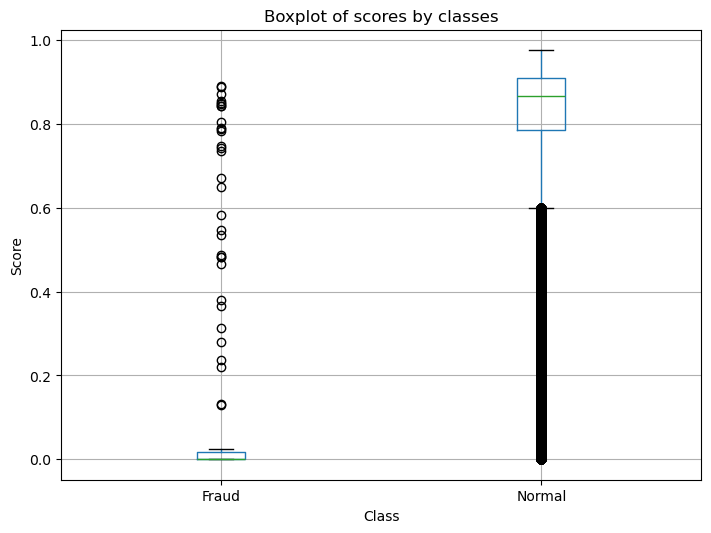

In [164]:
results.boxplot(column='pred', by='class', figsize=(8, 6))

# Ajouter des labels et un titre
plt.title("Boxplot of scores by classes")
plt.suptitle("")  # Supprime le titre automatique de pandas
plt.xlabel("Class")
plt.ylabel("Score")
plt.xticks(ticks=[1, 2], labels=['Fraud', 'Normal'])

# Afficher le graphique
plt.show()